# 03. Modeling and Evaluation

## 1. Setup and Data Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# Load processed data
try:
    df = pd.read_csv('data/processed/processed_data.csv')
    print(f"Dataset Shape: {df.shape}")
except FileNotFoundError:
    print("Processed data not found. Please run 01_Data_Preprocessing.ipynb first.")

Dataset Shape: (5000, 36)


## 2. Data Preparation

In [ ]:
# Define Features and Targets
# For Regression: Predict Engagement_Rate.
X_reg = df.drop(columns=['Engagement_Rate', 'Engagement_Level_Encoded'])
y_reg = df['Engagement_Rate']

# For Classification: Predict Engagement_Level.
X_clf = df.drop(columns=['Engagement_Level_Encoded'])
y_clf = df['Engagement_Level_Encoded']

# Split Data for Regression
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Split Data for Classification
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42
)

# Scale Features (Important for Linear/Logistic Regression)
scaler_r = StandardScaler()
X_train_r_scaled = scaler_r.fit_transform(X_train_r)
X_test_r_scaled = scaler_r.transform(X_test_r)

scaler_c = StandardScaler()
X_train_c_scaled = scaler_c.fit_transform(X_train_c)
X_test_c_scaled = scaler_c.transform(X_test_c)

print("Data Split and Scaled.")

Data Split and Scaled.


In [3]:
X_train_r.head()

,Views,Likes,Shares,Comments,Month,DayOfWeek,Is_Weekend,Likes_Per_View,Shares_Per_View,Comments_Per_View,...,Content_Type_Shorts,Content_Type_Tweet,Content_Type_Video,Region_Brazil,Region_Canada,Region_Germany,Region_India,Region_Japan,Region_UK,Region_USA
4227,1003601,488570,58252,33282,3,4,0,0.486817,0.058043,0.033163,...,False,True,False,False,False,False,False,False,False,True
4676,2366043,87673,4121,25516,11,2,0,0.037055,0.001742,0.010784,...,True,False,False,False,False,False,False,False,False,False
800,34258,99120,37011,3149,3,2,0,2.893339,1.080361,0.091920,...,False,False,False,False,True,False,False,False,False,False
3671,725454,149682,27039,47514,3,3,0,0.206329,0.037272,0.065496,...,False,False,False,False,False,False,False,True,False,False
4193,544588,266292,32491,20402,8,0,0,0.488979,0.059662,0.037463,...,True,False,False,False,False,False,False,False,False,True


## 3. Regression Modeling (Predicting Engagement Rate)

In [4]:
from sklearn.model_selection import KFold

reg_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

reg_params = {
    'Linear Regression': {},
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    }
}

reg_results = {}
best_reg_models = {}

print("Training and Tuning Regression Models...")
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in reg_models.items():
    print(f"\nProcessing {name}...")
    
    # Select data
    if name == 'Linear Regression':
        X_train = X_train_r_scaled
        X_test = X_test_r_scaled
    else:
        X_train = X_train_r
        X_test = X_test_r
        
    # K-Fold CV (Baseline)
    cv_scores = cross_val_score(model, X_train, y_train_r, cv=kf, scoring='r2')
    print(f"  Baseline CV R2: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    
    # GridSearchCV
    if reg_params[name]:
        print(f"  Tuning {name}...")
        grid = GridSearchCV(model, reg_params[name], cv=3, scoring='r2', n_jobs=-1)
        grid.fit(X_train, y_train_r)
        best_model = grid.best_estimator_
        print(f"  Best Params: {grid.best_params_}")
    else:
        best_model = model
        best_model.fit(X_train, y_train_r)
        
    best_reg_models[name] = best_model
    
    # Evaluate on Test Set
    preds = best_model.predict(X_test)
    mse = mean_squared_error(y_test_r, preds)
    r2 = r2_score(y_test_r, preds)
    
    reg_results[name] = {
        'CV Mean R2': cv_scores.mean(),
        'Test MSE': mse, 
        'Test R2': r2
    }
    print(f"  Test MSE: {mse:.4f}, Test R2: {r2:.4f}")

Training and Tuning Regression Models...

Processing Linear Regression...
  Baseline CV R2: 1.0000 (+/- 0.0000)
  Test MSE: 0.0000, Test R2: 1.0000

Processing Random Forest...
  Baseline CV R2: 0.9301 (+/- 0.0731)
  Tuning Random Forest...
  Best Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
  Test MSE: 493854.1665, Test R2: 0.4605

Processing Gradient Boosting...
  Baseline CV R2: 0.9333 (+/- 0.0741)
  Tuning Gradient Boosting...
  Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
  Test MSE: 439839.7384, Test R2: 0.5195

Processing XGBoost...
  Baseline CV R2: 0.5327 (+/- 0.2102)
  Tuning XGBoost...
  Best Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
  Test MSE: 661703.2962, Test R2: 0.2771


## 4. Classification Modeling (Predicting Engagement Level)

In [5]:
from sklearn.model_selection import StratifiedKFold

clf_models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss')
}

clf_params = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    }
}

clf_results = {}
best_clf_models = {}

print("Training and Tuning Classification Models...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in clf_models.items():
    print(f"\nProcessing {name}...")
    
    # Select data
    if name == 'Logistic Regression':
        X_train = X_train_c_scaled
        X_test = X_test_c_scaled
    else:
        X_train = X_train_c
        X_test = X_test_c
        
    # K-Fold CV (Baseline)
    cv_scores = cross_val_score(model, X_train, y_train_c, cv=skf, scoring='accuracy')
    print(f"  Baseline CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    
    # GridSearchCV
    if clf_params[name]:
        print(f"  Tuning {name}...")
        grid = GridSearchCV(model, clf_params[name], cv=3, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train, y_train_c)
        best_model = grid.best_estimator_
        print(f"  Best Params: {grid.best_params_}")
    else:
        best_model = model
        best_model.fit(X_train, y_train_c)
        
    best_clf_models[name] = best_model
    
    # Evaluate on Test Set
    preds = best_model.predict(X_test)
    acc = accuracy_score(y_test_c, preds)
    f1 = f1_score(y_test_c, preds, average='weighted')
    
    clf_results[name] = {
        'CV Mean Accuracy': cv_scores.mean(),
        'Test Accuracy': acc, 
        'Test F1-Score': f1
    }
    print(f"  Test Accuracy: {acc:.4f}, Test F1-Score: {f1:.4f}")

Training and Tuning Classification Models...

Processing Logistic Regression...
  Baseline CV Accuracy: 0.9870 (+/- 0.0017)
  Tuning Logistic Regression...
  Best Params: {'C': 10}
  Test Accuracy: 0.9870, Test F1-Score: 0.9870

Processing Random Forest...
  Baseline CV Accuracy: 0.9988 (+/- 0.0008)
  Tuning Random Forest...
  Best Params: {'max_depth': 20, 'n_estimators': 100}
  Test Accuracy: 1.0000, Test F1-Score: 1.0000

Processing Gradient Boosting...
  Baseline CV Accuracy: 0.9992 (+/- 0.0006)
  Tuning Gradient Boosting...
  Best Params: {'learning_rate': 0.05, 'n_estimators': 100}
  Test Accuracy: 1.0000, Test F1-Score: 1.0000

Processing XGBoost...
  Baseline CV Accuracy: 0.9970 (+/- 0.0015)
  Tuning XGBoost...
  Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
  Test Accuracy: 0.9980, Test F1-Score: 0.9980


## 5. Model Performance Summary

In [6]:
print("\n--- Regression Model Performance ---")
reg_df = pd.DataFrame(reg_results).T
display(reg_df.sort_values(by='Test R2', ascending=False))

print("\n--- Classification Model Performance ---")
clf_df = pd.DataFrame(clf_results).T
display(clf_df.sort_values(by='Test Accuracy', ascending=False))


--- Regression Model Performance ---


,CV Mean R2,Test MSE,Test R2
Linear Regression,1.000000,1.080210e-24,1.000000
Gradient Boosting,0.933315,4.398397e+05,0.519514
Random Forest,0.930108,4.938542e+05,0.460507
XGBoost,0.532658,6.617033e+05,0.277147



--- Classification Model Performance ---


,CV Mean Accuracy,Test Accuracy,Test F1-Score
Random Forest,0.99875,1.000,1.000000
Gradient Boosting,0.99925,1.000,1.000000
XGBoost,0.99700,0.998,0.998000
Logistic Regression,0.98700,0.987,0.987017


## 6. Feature Importance Analysis

Best Regression Model: Linear Regression
DEBUG: Linear Regression Importances shape: (34,)


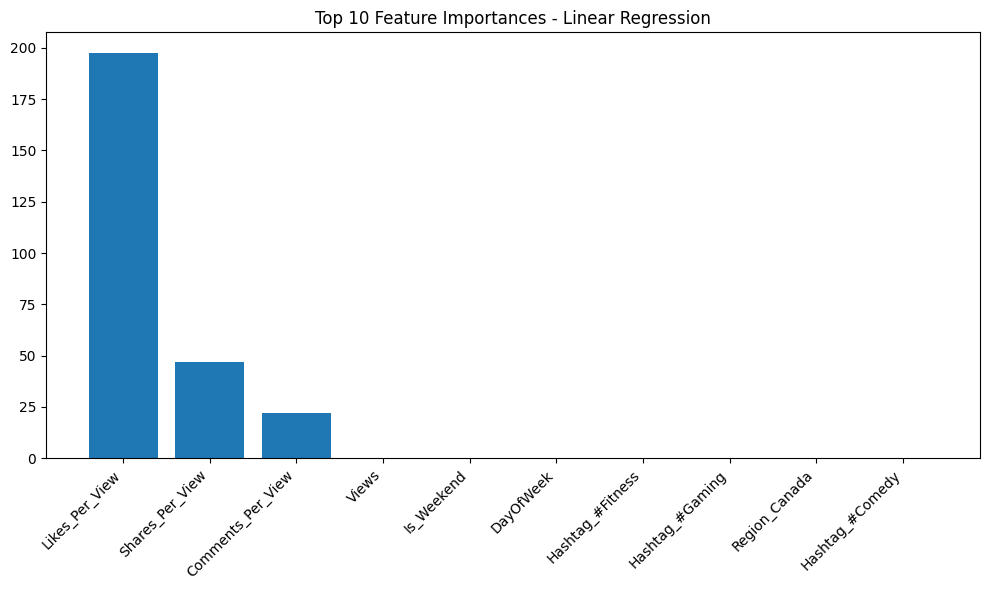

Best Classification Model: Random Forest
DEBUG: Random Forest Importances shape: (35,)


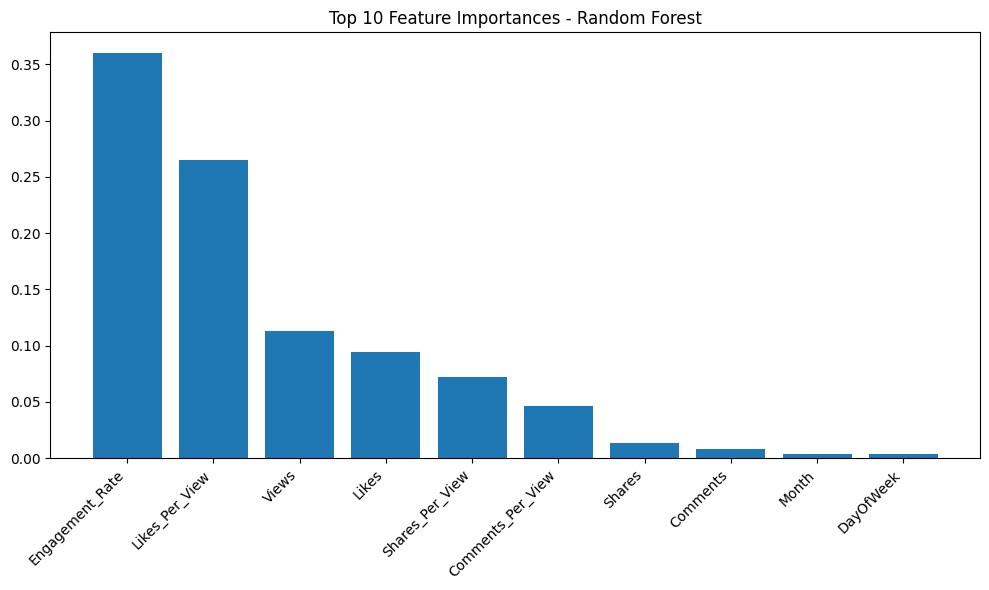

In [7]:
# Feature Importance Visualization
def plot_feature_importance(model, feature_names, title):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        if model.coef_.ndim > 1:
            importances = np.abs(model.coef_[0])
        else:
            importances = np.abs(model.coef_)
    else:
        print(f"Model {title} does not have feature importances.")
        return

    importances = np.array(importances).flatten()
    
    if len(importances) == 0:
        print(f"No feature importances found for {title}")
        return

    print(f"DEBUG: {title} Importances shape: {importances.shape}")
    indices = np.argsort(importances)[::-1]
    top_n = min(10, len(importances))
    
    top_importances = importances[indices[:top_n]]
    top_feature_names = [feature_names[i] for i in indices[:top_n]]
    
    plt.figure(figsize=(10, 6))
    plt.title(f"Top {top_n} Feature Importances - {title}")
    plt.bar(range(top_n), top_importances, align="center")
    plt.xticks(range(top_n), top_feature_names, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot for best Regression Model
best_reg_name = max(reg_results, key=lambda x: reg_results[x]['Test R2'])
print(f"Best Regression Model: {best_reg_name}")
plot_feature_importance(best_reg_models[best_reg_name], X_reg.columns, best_reg_name)

# Plot for best Classification Model
best_clf_name = max(clf_results, key=lambda x: clf_results[x]['Test Accuracy'])
print(f"Best Classification Model: {best_clf_name}")
plot_feature_importance(best_clf_models[best_clf_name], X_clf.columns, best_clf_name)